# Imports

In [1]:
# imports
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
import qml_mor

# Model Definition

In [3]:
# feature layer
def feature_layer(x):
    num_qubits = len(x)
    qml.IQPEmbedding(x, wires=range(num_qubits))

In [4]:
# variational layer
def variational_layer(init_theta, theta, num_qubits):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_theta, weights=theta, wires=range(num_qubits))

In [5]:
# observable / output layer
def sequence_generator(n):
    if n == 0:
        return [[]]
    else:
        sequences = []
        for sequence in sequence_generator(n-1):
            sequences.append(sequence + [n-1])
            sequences.append(sequence)
        return sequences
    
def parities(n):
    
    seq = sequence_generator(n)
    ops = []
    for par in seq:
        if par:
            tmp = qml.PauliZ(par[0])
            if len(par) > 1:
                for i in par[1:]:
                    tmp = tmp @ qml.PauliZ(i)

            ops.append(tmp)

    ops.append(qml.Identity(0))

    return ops

In [6]:
# device
num_qubits = 3
shots      = None
dev        = qml.device('default.qubit', wires=num_qubits, shots=shots)

FileNotFoundError: [Errno 2] No such file or directory: '/home/test/anaconda3/envs/QML-MOR/lib/python3.10/site-packages/PennyLane_Lightning-0.28.2.dist-info/METADATA'

In [ ]:
from pennylane.templates import IQPEmbedding, SimplifiedTwoDesign
# QNN model
@qml.qnode(dev, interface='torch')
def qnn_model(x, init_theta, theta, W, omega=0.):

    num_qubits = len(x)
    shape_init = init_theta.shape
    reps       = 1
    if len(shape_init) < 1:
        init_theta = [init_theta]
        shape_init = init_theta.shape
    reps       = shape_init[0]

    shape_theta = theta.shape
    reps_       = 1
    if len(shape_theta) < 3:
        theta       = [theta]
        shape_theta = theta.shape
    reps_       = shape_theta[0]

    assert reps == reps_
    for l in range(reps):
        qml.IQPEmbedding(features=2**(omega*l)*x, wires=range(num_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_theta[l], weights=theta[l], wires=range(num_qubits))

    obs = parities(num_qubits)
    H   = qml.Hamiltonian(W, obs)

    return qml.expval(H)

In [ ]:
import pennylane as qml
from pennylane.templates import IQPEmbedding

n_wires = 3
n_layers = 2

dev = qml.device("default.qubit", wires=n_wires)
@qml.qnode(dev, interface='torch')
def iqpe_circuit(features):
    for layer in range(n_layers):
        # Apply the IQPEmbedding template in a loop
        IQPEmbedding(features=features[layer], wires=range(n_wires))

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_wires)]

features = np.random.random((n_layers, n_wires))

result1 = iqpe_circuit(features)

In [ ]:
num_qubits  = 3
num_reps    = 0
num_layers  = 0
omega       = 1.
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

result1 = qnn_model(x, init_theta, theta, W)
result2 = qnn_model(x, init_theta, theta, W)

ret = torch.stack([result1, result2])
result1.size()

torch.Size([])

In [41]:
from scipy.stats import qmc
def generate_samples_r(d, S):
    sampler = qmc.LatinHypercube(d=d)
    r_samples = sampler.random(n=S)
    return r_samples
r = generate_samples_r(10, 2)
print(len(r[0]))

tmp = set()
rng = np.random.default_rng(seed=0)
b1 = tuple(rng.integers(0, 2, size=4))
b2 = tuple(rng.integers(0, 2, size=4))
tmp.add(b1)
tmp.add(b2)
print(tmp)
arr = np.array(list(tmp))
print(arr)
arr[0, 3]

10
{(1, 1, 1, 0), (0, 0, 0, 0)}
[[1 1 1 0]
 [0 0 0 0]]


0

In [3]:
import torch
X = torch.rand(2, 3)
params = torch.rand(3)
print(X)
print(params)
print(X[0]*params)
print(torch.sum(X[0]*params))

tensor([[0.7108, 0.0386, 0.4734],
        [0.0220, 0.8784, 0.2833]])
tensor([0.5415, 0.2427, 0.9673])
tensor([0.3849, 0.0094, 0.4579])
tensor(0.8522)


In [9]:
import pennylane as qml
import torch
import torch.optim as optim
import torch.nn as nn

# Define the quantum device
dev = qml.device("default.qubit", wires=2)

# Define the custom model as a PennyLane QNode
@qml.qnode(dev, interface="torch")
def custom_model(x, y):
    # Apply your quantum circuit here, which uses input x and trainable parameters y
    # As an example, we'll use a simple circuit with one rotation gate parameterized by y:
    qml.RY(y[0], wires=0)
    qml.RX(x, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

# Define the dataset (x_data, y_data)
x_data = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5], dtype=torch.float32)
y_data = torch.tensor([0.5, 0.4, 0.3, 0.2, 0.1], dtype=torch.float32)

# Initialize the trainable parameters
params = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)

# Set the hyperparameters
learning_rate = 0.01
epochs = 100
loss_fn = nn.MSELoss()
optimizer = optim.Adam([params], lr=learning_rate)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    predictions = torch.tensor([custom_model(x, params) for x in x_data], dtype=torch.float32)
    loss = loss_fn(predictions, y_data)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

print(f"Trained parameters: {params}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [165]:
num_qubits  = 3
num_reps    = 3
num_layers  = 0
omega       = 1.
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)
def qnn_model(x, init_theta, theta, W, omega=0.):

    num_qubits = len(x)
    shape_init = init_theta.shape
    reps       = 1
    if len(shape_init) < 1:
        init_theta = [init_theta]
        shape_init = init_theta.shape
    reps       = shape_init[0]

    shape_theta = theta.shape
    reps_       = 1
    if len(shape_theta) < 3:
        theta       = [theta]
        shape_theta = theta.shape
    reps_       = shape_theta[0]

    assert reps == reps_
    for l in range(reps):
        qml.IQPEmbedding(features=2**(omega*l)*x, wires=range(num_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_theta[l], weights=theta[l], wires=range(num_qubits))

    obs = parities(num_qubits)
    H   = qml.Hamiltonian(W, obs)

    return qml.expval(H)

result = qnn_model(x, init_theta, theta, W)
print(result.shape())

(1,)


In [155]:
tmp = parities(3)
for x in tmp:
    print(type(x))
    print(issubclass(type(x), qml.operation.Observable))

<class 'pennylane.operation.Tensor'>
True
<class 'pennylane.operation.Tensor'>
True
<class 'pennylane.operation.Tensor'>
True
<class 'pennylane.ops.qubit.non_parametric_ops.PauliZ'>
True
<class 'pennylane.operation.Tensor'>
True
<class 'pennylane.ops.qubit.non_parametric_ops.PauliZ'>
True
<class 'pennylane.ops.qubit.non_parametric_ops.PauliZ'>
True
<class 'pennylane.ops.identity.Identity'>
True


2
4
3
(<Figure size 900x400 with 1 Axes>, <Axes: >)


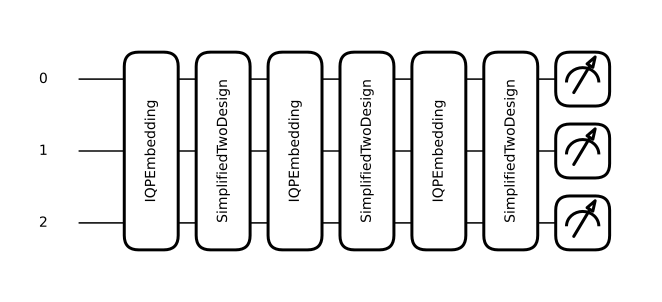

In [127]:
# example
num_qubits  = 3
num_reps    = 3
num_layers  = 0
omega       = 1.
x           = torch.randn(num_qubits, requires_grad=False)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

print(qml.draw_mpl(qnn_model)(x, init_theta, theta, W, omega))

# Datasets for Capacity Estimation

In [ ]:
def gen_dataset(N, samples=10, seed=0):
    sizex   = num_qubits
    scale   = 2.
    shift   = -1.

    torch.manual_seed(seed)
    x       = scale*torch.rand(N, sizex, requires_grad=False) + shift
    y       = scale*torch.rand(samples, N, requires_grad=False) + shift

    return x, y

# Training

In [ ]:
# model specs
num_qubits  = 3
num_reps    = 2
num_layers  = 2
omega       = 1.

In [137]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [ ]:
# initial parameters
seed = 0
torch.manual_seed(seed)
init_theta  = torch.randn(num_reps, num_qubits, requires_grad=True)
theta       = torch.randn(num_reps, num_layers, num_qubits-1, 2, requires_grad=True)
W           = torch.randn(2**num_qubits, requires_grad=True)

In [ ]:
# loss function
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [ ]:
# capacity estimation parameters
Nmin     = 1
Nmax     = 5
samples  = 10
steps    = 300
eps_stop = 1e-12

In [ ]:
summary = {}
for N in range(Nmin, Nmax):
    x, y = gen_dataset(N, samples)
    
    mre_sample = []
    for s in range(samples):
        print('===================================')
        def cost(init_theta, theta, W):
            pred = [qnn_model(x[k], init_theta, theta, W) for k in range(N)]
            loss = square_loss(y[s], pred)
            return loss
        
        # optimize
        opt = torch.optim.Adam([init_theta, theta, W], lr=0.1, amsgrad=True)
        for n in range(steps):
            opt.zero_grad()
            loss = cost(init_theta, theta, W)
            loss.backward()
            opt.step()

            if n%10 == 9 or n == steps - 1:
                print(f'{n+1}: {loss}')

            if loss <= eps_stop:
                break

        # compute prediction errors
        y_pred = torch.tensor([qnn_model(x[k], init_theta, theta, W) for k in range(N)], requires_grad=False)
        mre    = torch.mean(torch.abs((y[s]-y_pred)/y_pred))
        mre_sample.append(mre)

    mre_N = torch.mean(torch.tensor(mre_sample))
    summary[f'N = {N}'] = mre_N.item()

In [136]:
for count, eps in enumerate(summary.values()):
    m = int(np.log2(1./eps.item()))
    C = (count+1)*m
    print(C)
print(torch.numel(init_theta))

10
26
45
64
9


In [ ]:
C = [-0.5, 13.1, 2]
max(C)

# Summary

In [ ]:
y_pred = torch.tensor([qnn_model(x[k], init_theta, theta, W) for k in range(N)], requires_grad=False)
mre    = torch.mean(torch.abs((y[s]-y_pred)/y_pred))
print(mre.item())

In [ ]:
# cutoff precision converted to bits of precision
cutoff = np.sqrt(eps_stop)
m      = np.log2(1./cutoff)
print(m)

In [ ]:
print(x)
print(init_theta)
print(theta)
print(W)
print(y[s])
print(y_pred)